# Sementic segmentation of flair1 data with a basic UNet

In [2]:
#!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

/home/bertille/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'swimming_pool',
14  : 'snow',
15  : 'clear cut',
16  : 'mixed',
17  : 'ligneous',
18  : 'greenhouse',
19  : 'other'}

colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

## Prepare the data
1) Download the data and split it into training, validation and test sets.
2) Analyse the balance of classes in the dataset.
3) Create a Dataloader
4) Load the data

In [3]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, seed = 42):
        super(Flair1Dataset, self).__init__()
        self.resize_transform = transforms.Resize((256, 256))
        self.resize_transform_l = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = len(dict_classes)
        self.n_inputs = 3

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        data = rasterio.open(img_path).read()
        data = data[0:3, :, :]
        label = rasterio.open(mask_path).read()
        label = label - 1
        # Convert data to PIL Image for resizing
        data = np.transpose(data, (1, 2, 0))
        data = transforms.ToPILImage()(data)
        data = self.resize_transform(data)
        # Convert back to tensor
        data = transforms.ToTensor()(data)

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return data, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,20), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,20):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,20):
            class_per[j] = class_per[j] / total_pixels
        return class_per


In [10]:
folder_path = '../data/flair1_subset/'#'LandCover_map_Transformers_SSL/data/flair1_subset/'
train_path = '../data/flair1_subset/train_500'
val_path = '../data/flair1_subset/val_100'
test_path = '../data/flair1_subset/test_100'
#train_path = 'drive/MyDrive/MVA/flair1_fullset/train'
#val_path = 'drive/MyDrive/MVA/flair1_fullset/val'
#test_path = 'drive/MyDrive/MVA/flair1_fullset/test'
batch_size = 32
use_gpu = True
max_epochs = 10

In [11]:
train_ds = Flair1Dataset(train_path)
val_ds = Flair1Dataset(val_path)
test_ds = Flair1Dataset(test_path)

In [12]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

torch.Size([256, 256, 3])


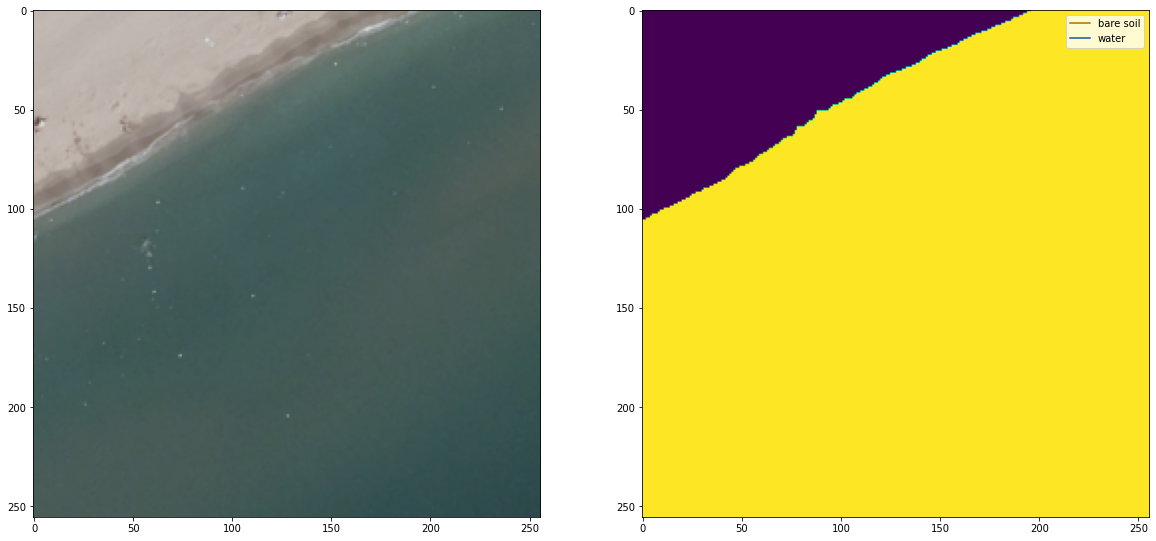

In [13]:
#train_ds = Flair1Dataset(train_path)
#train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
img, msk = next(iter(train_dl))
plot_image_mask(img[0], msk[0], colors, dict_classes)

## Create the model

In [14]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


### Define metric: pixel-wise accuracy and MIoU

In [15]:
class ConfMatrix():

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.state = np.zeros((self.num_classes, self.num_classes))

    def calc(self, gt, pred):
        """ calcs and returns the CM without saveing it to state """
        return confusion_matrix(gt.flatten(),
                                pred.flatten(),
                                labels=np.arange(self.num_classes))

    def get_existing_classes(self):
        return sum(np.sum(self.state, axis=1) > 0)

    def add(self, gt, pred):
        """ adds one label mask to the confusion matrix """

        assert gt.shape == pred.shape
        assert gt.shape == (256, 256)

        gt = gt.flatten()
        pred = pred.flatten()
        pred = pred[gt != 255]
        gt = gt[gt != 255]

        if not gt.size == 0:
            self.state += confusion_matrix(gt, pred,
                                           labels=np.arange(self.num_classes))

        return None

    def add_batch(self, gt, pred):
        """ adds a batch of label masks to the confusion matrix """

        # convert pytorch tensors to numpy arrays
        if not isinstance(gt, np.ndarray):
            gt = gt.cpu().numpy()
            pred = pred.cpu().numpy()

        assert len(gt.shape) == 3       # assert C x W x H

        noc = gt.shape[0]               # number of channels
        for batchindex in range(noc):   # iterate over batch
            self.add(gt[batchindex], pred[batchindex])

        return None

    def norm_on_lines(self):
        """ norms along the lines of the matrix """

        a = self.state
        b = np.sum(self.state, axis=1)[:, None]
        return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

    def get_aa(self):
        confmatrix = self.norm_on_lines()
        return np.diagonal(confmatrix).sum() / self.get_existing_classes()

    def get_IoU(self):
        res = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            cm = self.state
            a = cm[i, i]
            b = (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            res[i] = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        return res

    def get_mIoU(self):
        return np.mean(self.get_IoU())


def AA(gt, pred, num_classes):
    """ This is the mean over the diagonal of the confusion
    matrix when it's normed """

    cm = ConfMatrix(num_classes)
    cm.add(gt, pred)
    confmatrix = cm.norm_on_lines()

    return np.mean(np.diagonal(confmatrix))


def IoU(gt, pred, num_classes):
    """
    the intersection over union for class i can be calculated as follows:


    get the intersection:
        >>> thats the element [i,i] of the confusion matrix (cm)

    the union:
        >>> is the sum over row with index i plus the sum over line with index
        i minux the diagonal element [i,i] (otherwise its counted twice)

    """

    cm = ConfMatrix(num_classes).calc(gt, pred)

    res = np.zeros(num_classes)
    for i in range(num_classes):
        res[i] = cm[i, i] / (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])

    return res


def mIoU(gt, pred, num_classes):
    return np.mean(IoU(gt, pred, num_classes))

class PixelwiseMetrics(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

        # Initialize dictionaries to store class-wise statistics
        self.data = {"pixelclass_" + str(i): {"correct": 0, "total": 0} for i in range(num_classes)}

    def add_batch(self, y, y_hat):
        for c in range(self.num_classes):
            class_data = self.data["pixelclass_" + str(c)]
            preds_c = y_hat == c
            targs_c = y == c
            num_correct = (preds_c * targs_c).sum().cpu().detach().numpy()
            num_pixels = np.sum(targs_c.cpu().detach().numpy())

            # Update class-wise statistics
            class_data["correct"] += num_correct
            class_data["total"] += num_pixels

    def get_classwise_accuracy(self):
        cw_acc_ = {k: el['correct'] / el['total'] if el['total'] > 0 else 0.0 for k, el in self.data.items()}
        return cw_acc_

    def get_average_accuracy(self):
        cw_acc = self.get_classwise_accuracy()
        return np.mean(list(cw_acc.values()))

## Create the functions for training, validation and test, with plots of the loss

In [14]:
# main training function (trains for one epoch)
def train(model, train_loader, loss_fn, optimizer):

    # set model to train mode
    model.train()

    # main training loop
    pbar = tqdm(total=len(train_loader), desc="[Train]")
    training_loss = 0
    pixel_acc = PixelwiseMetrics(train_loader.dataset.n_classes)
    conf_mat = ConfMatrix(train_loader.dataset.n_classes)
    for batch_idx, (image, target) in enumerate(train_loader):
        #print(image.shape)
        # reset gradients
        optimizer.zero_grad()

        # move data to gpu if model is on gpu
        if use_gpu:
            image, target = image.cuda(), target.cuda()

        # forward pass
        prediction = model(image)
        #print(target.shape)
        training_loss += loss_fn(prediction, target).data.item()
        loss = loss_fn(prediction, target)
        pixel_acc.add_batch(target, prediction.max(1)[1])
        conf_mat.add_batch(target, prediction.max(1)[1])
        # backward pass
        loss.backward()
        optimizer.step()

        # update progressbar

        '''    pbar.set_description("[Train] Loss: {:.4f}".format(
                                round(training_loss.item(), 4)))
        pbar.set_description("[Train] Pixel-wise accuracy: {:.2f}%".format(
                                round(pixel_acc.get_average_accuracy() * 100, 2)))
        pbar.set_description("[Train] mIoU: {:.2f}%".format(
                                round(conf_mat.get_mIoU()) * 100, 2))'''
        pbar.update()

    # close progressbar and flush to disk
    pbar.close()
    training_loss /= len(train_loader)
    return model, training_loss, pixel_acc.get_average_accuracy(), pixel_acc.get_classwise_accuracy(), conf_mat.get_mIoU()

# main validation function (validates current model)
def val(model, val_loader, loss_fn, optimizer):

    # set model to evaluation mode
    model.eval()

    # main validation loop
    pbar = tqdm(total=len(val_loader), desc="[Val]")
    loss = 0
    val_pixel_acc = PixelwiseMetrics(val_loader.dataset.n_classes)
    val_conf_mat = ConfMatrix(val_loader.dataset.n_classes)

    for batch_idx, (image, target) in enumerate(val_loader):

        # move data to gpu if model is on gpu
        if use_gpu:
            image, target = image.cuda(), target.cuda()

        # forward pass
        with torch.no_grad():
            prediction = model(image)
        loss += loss_fn(prediction, target).cpu().item()

        # calculate error metrics
        val_conf_mat.add_batch(target, prediction.max(1)[1])
        val_pixel_acc.add_batch(target, prediction.max(1)[1])

        # update progressbar
        pbar.update()

    '''    # close progressbar
    pbar.set_description("[Val] Pixel-wise accuracy: {:.2f}%".format(
                            round(val_pixel_acc.get_average_accuracy() * 100, 2)))'''
    pbar.close()

    model.train()
    return loss / len(val_loader), val_pixel_acc.get_average_accuracy(), val_pixel_acc.get_classwise_accuracy(), val_conf_mat.get_mIoU()

def export_model(model, optimizer=None, name=None, step=None):

    # set output filename
    if name is not None:
        out_file = name
    else:
        out_file = "checkpoint"
        if step is not None:
            out_file += "_step_" + str(step)
    out_file = os.path.join(self.args.checkpoint_dir, out_file + ".pth")

    # save model
    data = {"model_state_dict": model.state_dict()}
    if step is not None:
        data["step"] = step
    if optimizer is not None:

        data["optimizer_state_dict"] = optimizer.state_dict()
    torch.save(data, out_file)

## Run the algorithm

Epoch:  0


[Val]: 100%|██████████| 13/13 [00:44<00:00,  3.44s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.7465742918161244
Training mean accuracy:  0.13476495940866787
Training classwise accuracy:  {'pixelclass_0': 0.13545283085453028, 'pixelclass_1': 0.17314390622656753, 'pixelclass_2': 0.5869500070479978, 'pixelclass_3': 8.209141224922557e-05, 'pixelclass_4': 0.019338172180680294, 'pixelclass_5': 0.00012628165697828363, 'pixelclass_6': 0.7312778290251752, 'pixelclass_7': 0.07058463431350985, 'pixelclass_8': 0.03429404707440033, 'pixelclass_9': 0.7238438576027524, 'pixelclass_10': 0.048664989590975635, 'pixelclass_11': 0.020661362259240496, 'pixelclass_12': 0.00027926027057217326, 'pixelclass_13': 0.0, 'pixelclass_14': 0.002092759053674287, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.013733095712338819, 'pixelclass_18': 9.104483047452565e-06}
Training mIoU:  0.026779266848837906
-----------------------
Validati

[Val]: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.5776914931260622
Training mean accuracy:  0.14942355464711576
Training classwise accuracy:  {'pixelclass_0': 0.12824129804845724, 'pixelclass_1': 0.20268273096255157, 'pixelclass_2': 0.6836696442192467, 'pixelclass_3': 0.0013945649550772055, 'pixelclass_4': 0.0017646825216029252, 'pixelclass_5': 0.013448996468187207, 'pixelclass_6': 0.7905729702130678, 'pixelclass_7': 0.11608211111787328, 'pixelclass_8': 0.0969005445087653, 'pixelclass_9': 0.7686555477124857, 'pixelclass_10': 0.008802184361690278, 'pixelclass_11': 0.02683226320619413, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.05556962319291761
-----------------------
Validation loss:  1.9249611817873442
Validation mean accuracy:  0.13106464879453203

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.4753676561208873
Training mean accuracy:  0.18041901127108134
Training classwise accuracy:  {'pixelclass_0': 0.19867113151837634, 'pixelclass_1': 0.2208336760017609, 'pixelclass_2': 0.710284170197007, 'pixelclass_3': 0.0, 'pixelclass_4': 0.052898813255267914, 'pixelclass_5': 0.006770326254771206, 'pixelclass_6': 0.7753047555175495, 'pixelclass_7': 0.12735045705745368, 'pixelclass_8': 0.5853248849408992, 'pixelclass_9': 0.730825464155739, 'pixelclass_10': 0.019697535251721052, 'pixelclass_11': 0.0, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.10027990019215399
-----------------------
Validation loss:  1.8336703869012685
Validation mean accuracy:  0.18355555218213804
Validation classwise accuracy:  {'pix

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.4439174487040594
Training mean accuracy:  0.1876320347229109
Training classwise accuracy:  {'pixelclass_0': 0.1925198702892612, 'pixelclass_1': 0.19043720114417853, 'pixelclass_2': 0.7080405877704012, 'pixelclass_3': 0.0, 'pixelclass_4': 0.024785225492219242, 'pixelclass_5': 0.09479963989359752, 'pixelclass_6': 0.7651213283843257, 'pixelclass_7': 0.13074375094706558, 'pixelclass_8': 0.6828886555825592, 'pixelclass_9': 0.7582147153832026, 'pixelclass_10': 0.013493515196095023, 'pixelclass_11': 0.003964169652401616, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.08035882391554883
-----------------------
Validation loss:  1.9883249356196477
Validation mean accuracy:  0.15919628647490705
Validation classwise

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.390534907579422
Training mean accuracy:  0.2006654160325697
Training classwise accuracy:  {'pixelclass_0': 0.2151869003132977, 'pixelclass_1': 0.25628586356244776, 'pixelclass_2': 0.7401342525806724, 'pixelclass_3': 0.0, 'pixelclass_4': 0.03218992398684248, 'pixelclass_5': 0.05834782856654025, 'pixelclass_6': 0.7705005682236346, 'pixelclass_7': 0.2261674339128539, 'pixelclass_8': 0.7356101195592097, 'pixelclass_9': 0.7494573510856478, 'pixelclass_10': 0.019781277803281913, 'pixelclass_11': 0.0069334763735335895, 'pixelclass_12': 0.002047908650862604, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.08980848032974421
-----------------------
Validation loss:  1.7298840926243708
Validation mean accuracy:  0.14986126067115393
Valid

[Val]: 100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.3671298347986662
Training mean accuracy:  0.20398917390931706
Training classwise accuracy:  {'pixelclass_0': 0.260386465852903, 'pixelclass_1': 0.2256177879814261, 'pixelclass_2': 0.7384335834013673, 'pixelclass_3': 9.890531596292238e-06, 'pixelclass_4': 0.11251453006404558, 'pixelclass_5': 0.06722013336972418, 'pixelclass_6': 0.7588659166343399, 'pixelclass_7': 0.15947134954045597, 'pixelclass_8': 0.7778268485045623, 'pixelclass_9': 0.7429589398658641, 'pixelclass_10': 0.03205790408124966, 'pixelclass_11': 0.0004309544494900754, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.0944008242971889
-----------------------
Validation loss:  1.5583774676689734
Validation mean accuracy:  0.16965850683606987
Valid

[Val]: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.3284839529257555
Training mean accuracy:  0.2118103333394745
Training classwise accuracy:  {'pixelclass_0': 0.30528861423602804, 'pixelclass_1': 0.22882447336757944, 'pixelclass_2': 0.7279368680582204, 'pixelclass_3': 0.0, 'pixelclass_4': 0.14335883185472445, 'pixelclass_5': 0.10140213375264275, 'pixelclass_6': 0.7549889724418172, 'pixelclass_7': 0.17572728797648818, 'pixelclass_8': 0.7838376452398016, 'pixelclass_9': 0.759109073601046, 'pixelclass_10': 0.033627560484130466, 'pixelclass_11': 0.0045234935123780965, 'pixelclass_12': 0.0057713789251582475, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.10479509954559015
-----------------------
Validation loss:  1.5288734986231878
Validation mean accuracy:  0.16377010605452644
Va

[Val]: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.3170409294275136
Training mean accuracy:  0.21359352802592982
Training classwise accuracy:  {'pixelclass_0': 0.32838030184802514, 'pixelclass_1': 0.22049832167339217, 'pixelclass_2': 0.7428412997450038, 'pixelclass_3': 0.0019553580965869753, 'pixelclass_4': 0.1382850346004954, 'pixelclass_5': 0.09496136188656648, 'pixelclass_6': 0.7249242233635098, 'pixelclass_7': 0.17679418353708437, 'pixelclass_8': 0.787567865255898, 'pixelclass_9': 0.759970245653588, 'pixelclass_10': 0.030102348652817523, 'pixelclass_11': 0.05199648817969884, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.11678245975705553
-----------------------
Validation loss:  1.3837102834994977
Validation mean accuracy:  0.1807519373575607
Valida

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.3064972827067742
Training mean accuracy:  0.2208634755408598
Training classwise accuracy:  {'pixelclass_0': 0.3284893090589698, 'pixelclass_1': 0.19671770871271624, 'pixelclass_2': 0.7325437039275647, 'pixelclass_3': 0.0, 'pixelclass_4': 0.22874334772188332, 'pixelclass_5': 0.1060126363129015, 'pixelclass_6': 0.760868308630261, 'pixelclass_7': 0.2152550403808842, 'pixelclass_8': 0.7727334833663458, 'pixelclass_9': 0.7440886398304586, 'pixelclass_10': 0.05909085780816663, 'pixelclass_11': 0.04848084736036579, 'pixelclass_12': 0.0033821521658185427, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.1497665979675527
-----------------------
Validation loss:  1.323101703937237
Validation mean accuracy:  0.22237161475110206
Validation

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Training loss:  1.2903055342344136
Training mean accuracy:  0.22668796802858543
Training classwise accuracy:  {'pixelclass_0': 0.31283853993075295, 'pixelclass_1': 0.24853314876463137, 'pixelclass_2': 0.7468149935009851, 'pixelclass_3': 9.98943691225516e-05, 'pixelclass_4': 0.22152747001343187, 'pixelclass_5': 0.11844078816048362, 'pixelclass_6': 0.7582410874784768, 'pixelclass_7': 0.1982325197625024, 'pixelclass_8': 0.7937747979799316, 'pixelclass_9': 0.7530391631009165, 'pixelclass_10': 0.03877756850085101, 'pixelclass_11': 0.08643616716448019, 'pixelclass_12': 0.03031525381655703, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Training mIoU:  0.031839330661165885
-----------------------
Validation loss:  4.101228879048274
Validation mean accuracy:  0.1003663

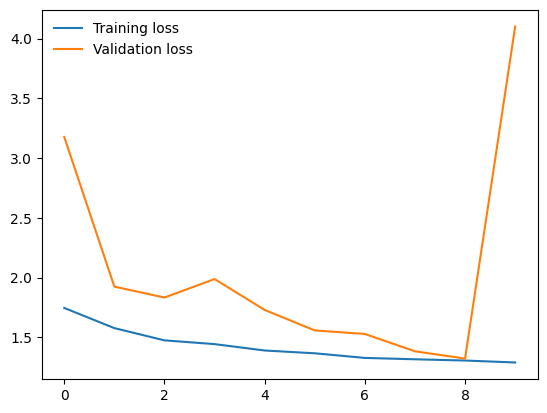

In [17]:
n_classes = train_ds.n_classes
n_inputs = train_ds.n_inputs
model = UNet(n_classes=n_classes, n_channels=n_inputs) #pixel value from 1 to 18
model = model.to('cuda' if torch.cuda.is_available() else 'cpu') # Move model to GPU if available
train_pixelAcc = PixelwiseMetrics(n_classes)
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=5e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    print("Epoch: ", epoch)
    # run training for one epoch
    model, tr_loss, tr_mean_acc, tr_class_acc, mIoU = train(model, train_dl, loss_fn, optimizer)
    train_losses.append(tr_loss)
    # run validation
    val_loss, val_mean_acc, val_class_acc, mIoU = val(model, val_dl, loss_fn, optimizer)
    val_losses.append(val_loss)
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")
    print("Training loss: ", tr_loss)
    print("Training mean accuracy: ", tr_mean_acc)
    print("Training classwise accuracy: ", tr_class_acc)
    print("Training mIoU: ", mIoU)
    print("-----------------------")
    print("Validation loss: ", val_loss)
    print("Validation mean accuracy: ", val_mean_acc)
    print("Validation classwise accuracy: ", val_class_acc)
    print("Validation mIoU: ", mIoU)
    #trainer.export_model(model, args.checkpoint_dir, name="final")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [18]:
# Run validation with the trained model on vl_dl
val_loss, val_mean_acc, val_class_acc, mIoU = val(model, val_dl, loss_fn, optimizer)
print("-----------------------")
print("Validation loss: ", val_loss)
print("Validation mean accuracy: ", val_mean_acc)
print("Validation classwise accuracy: ", val_class_acc)
print("Validation mIoU: ", mIoU)

[Val]: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it]

-----------------------
Validation loss:  4.101228915728056
Validation mean accuracy:  0.10036630007704041
Validation classwise accuracy:  {'pixelclass_0': 0.026427927558797016, 'pixelclass_1': 0.0, 'pixelclass_2': 0.7248313256980334, 'pixelclass_3': 0.0, 'pixelclass_4': 0.0, 'pixelclass_5': 0.0, 'pixelclass_6': 0.16235114508245183, 'pixelclass_7': 0.0, 'pixelclass_8': 0.9892384886302528, 'pixelclass_9': 0.004110814494232682, 'pixelclass_10': 0.0, 'pixelclass_11': 0.0, 'pixelclass_12': 0.0, 'pixelclass_13': 0.0, 'pixelclass_14': 0.0, 'pixelclass_15': 0.0, 'pixelclass_16': 0.0, 'pixelclass_17': 0.0, 'pixelclass_18': 0.0}
Validation mIoU:  0.031839330661165885


In [18]:
# print validation accuracy class by class
for i in range(len(val_class_acc)):
    print(i+1, dict_classes[i+1], " : ", val_class_acc["pixelclass_"+str(i)])

1 building  :  0.2503714665918761
2 pervious surface  :  0.13798490142569309
3 impervious surface  :  0.5868420231608982
4 bare soil  :  0.362831025675494
5 water  :  0.7809843260969862
6 coniferous  :  0.0
7 deciduous  :  0.7405613353211481
8 brushwood  :  0.43025763280052454
9 vineyard  :  0.9414259614199088
10 herbaceous vegetation  :  0.033195129601642476
11 agricultural land  :  0.0
12 plowed land  :  0.0
13 swimming_pool  :  0.0
14 snow  :  0.0
15 clear cut  :  0.0
16 mixed  :  0.0
17 ligneous  :  0.0
18 greenhouse  :  0.0
19 other  :  0.0


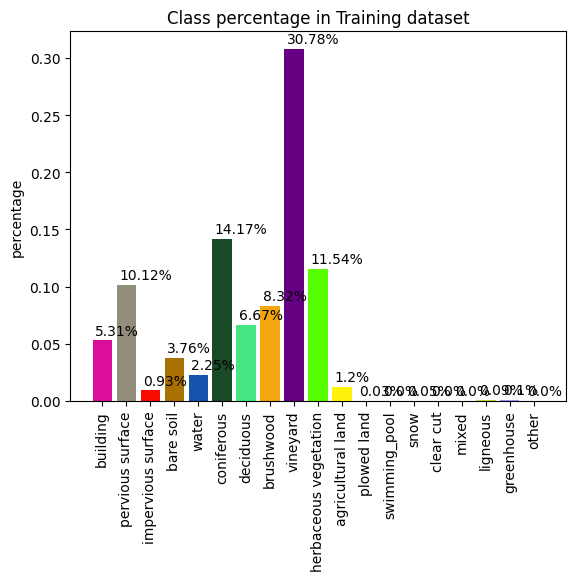

In [29]:
# call get_per_per_class() to get the percentage of each class in the dataset
per_class = train_ds.get_per_per_class()
plot_per_classes(per_class, dict_classes, colors, title = 'Training dataset')

In [25]:
torch.save(model.state_dict(), 'model_flair1_unet.pth')

In [ ]:
#plot confusion matrix for the test results
conf_mat = ConfMatrix(test_ds.n_classes)
test_pixel_acc = PixelwiseMetrics(test_ds.n_classes)
test_loss, test_mean_acc, test_class_acc, mIoU = val(model, test_dl, loss_fn, optimizer)
print("-----------------------")
print("Test loss: ", test_loss)
print("Test mean accuracy: ", test_mean_acc)
print("Test classwise accuracy: ", test_class_acc)
print("Test mIoU: ", mIoU)
for i in range(len(test_class_acc)):
    print(i+1, dict_classes[i+1], " : ", test_class_acc["pixelclass_"+str(i)])

# PLOT confusion matrix
conf_mat.calc(gt, pred)


In [ ]:
#NEXT STEP: 

# Confusion ConfMatrix
# IoU by class
# remove classes > 12 Ok
